In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Materials_Processes = pd.read_csv("Material_processes_2024_YTD.csv")

In [3]:
Materials_Processes.head(5)

,Material,Matl group,Size/dimensions
0,01010110,UNASSIGN,NaN
1,01010133,UNASSIGN,NaN
2,01186971,UNASSIGN,NaN
3,01189202F,UNASSIGN,NaN
4,01189203,UNASSIGN,NaN


In [4]:
Orders = pd.read_csv("Orders_YTD_2024.csv")

In [5]:
Orders.head(5)

,Order,Material Number,Order quantity (GMEIN),Confirmed quantity (GMEIN),Total scrap (GMEIN),Material description,Created on,Actual finish date,Time to complete
0,1054342,01500831,100,100,0,"FLYER, W&I INTERNAL FLYER",2024-03-20,2024-03-21,1
1,1054125,01500833,100,100,0,"FLYER, TRUE VALUE",2024-01-17,2024-01-17,0
2,1054086,01500835,100,100,0,"FLYER, ORGILL 2024 SHOW FLYER",2024-01-18,2024-01-18,0
3,1054206,01500836,100,100,0,"FLYER, DO IT BEST 2024 SHOW",2024-02-12,2024-02-12,0
4,1054181,01500838,100,100,0,"FLYER, ACE 2024 SHOW FLYER",2024-02-05,2024-02-05,0


In [6]:
#Start by renaming the columns of each dataframe.  Give them pythonic names instead of default labels from SAP.
Materials_Processes.columns = ["Material","Group","Dimensions"]

In [7]:
Orders.columns = ["WONumber","Material","OrderQuantity","ConfirmedQuantity","TotalScrap","Description","CreationDate","FinishDate","TimeinDays"]

In [8]:
#Make a list of the Unique Processes from the processes table.  We will want to split up any compound process descriptions.
Materials_Processes["Dimensions"].unique()

array([nan, 'FS', 'UV', 'GL', 'FSTI', 'THTI', 'SVTI', 'GLDX3ASST', 'GLTI',
       'GLDX43', 'SVFS', 'FSGL', 'GLDX38', 'FSTH', 'FSMC', 'SVMC', 'QX17',
       'SV', 'FSZ', 'FSCX77', 'TI', 'FS2', 'TH', 'CVP1', 'FSCW3', 'GLTH',
       'CX75', 'GLZ', 'GLDX46', 'GLEBX-CCC', 'EBX-DDDDX38',
       'GLEBX-IIIDX38', 'GLPI', 'PI', 'FSPI', 'GLEBX-TTTPI', 'FSGLPI',
       'AU', 'FSGLTI', 'UVTI', 'GLCVP1', 'FSCVP1', 'SVCX80', 'FS2CB7',
       'FSCB5', 'CX80', 'THMC', 'MC', 'GLMC', 'UVMC', 'FSGLMC',
       'GLEBX-VVVTI', 'GLCX81', 'FSCX83', 'FSGLDX41', 'FS2GL', 'FS2DX38',
       'FSEBX-RRR', 'UVDX38', 'THDX4ASST', 'THDX50', 'FSEBX-RRTI',
       'IN HOUSE', 'GLEBX-YYY', 'EBX-CC', 'EBX-4', 'EBX-84', 'EBX-75',
       'EBX-3', 'EBX-ASST', 'EBX-A', 'EBX-83', 'EBX-88', 'EBX-101',
       'GLEBX-OOOPI', 'FS2TI', 'GLEBX-WWW', 'SVFSEBX-XXXTI', 'FSCB21',
       'EBX88', 'GLEBX-K', 'DX3ASST', 'DX47', 'GLCX76', 'VP1', 'FSEASST',
       'FSGLNT1', 'FS2NT1', 'FS2NT4', 'FSNT4', 'FSNT1', 'FSE1NT2',
       'FSE2NT2', 

In [9]:
#We want to also model orders where there is no embellishing process applied to the cards.  Therefore, let's change
#records with "nan" to "NoProcess".
Materials_Processes["Dimensions"].fillna("NoProcess", inplace=True)

In [10]:
#For this first analysis notebook, we only want to determine a model predicting processing times
#based on a single process that does not involve a die cut.  So, we will only keep items with noprocess,FS,UV,GL,TI,SV,PI in the set.
Single_Processes = Materials_Processes[Materials_Processes["Dimensions"].isin(["NoProcess","FS","UV","GL","TI","SV","PI"])]

In [11]:
Single_Processes["Dimensions"].value_counts()

Dimensions
NoProcess    5953
GL            427
FS            370
UV            212
SV             79
TI             12
PI              3
Name: count, dtype: int64

In [12]:
#The above cell informs us that most production orders this year with a single process were either glitter (GL),
#Foil (FS), or ultraviolet treatment (UV).  Because these values are most abundant, we will build a model to predict total processing
#time based on these three categorical values, as well as the continuous factor, order quantity.  Orders that have more confirmed product (Confirmed Quantity)
#we expect to take more time, on average.
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [13]:
Single_Processes = Single_Processes[Single_Processes["Dimensions"].isin(["NoProcess","FS","UV","GL"])]

In [14]:
Single_Processes.head(5)

,Material,Group,Dimensions
0,01010110,UNASSIGN,NoProcess
1,01010133,UNASSIGN,NoProcess
2,01186971,UNASSIGN,NoProcess
3,01189202F,UNASSIGN,NoProcess
4,01189203,UNASSIGN,NoProcess


In [15]:
Single_Processes["Dimensions"].value_counts()

Dimensions
NoProcess    5953
GL            427
FS            370
UV            212
Name: count, dtype: int64

In [16]:
#Now, let's look at the unique material groups we have left.  It's quite a few, and because we are mostly interested in cards,
#rather than other products like magnet list pads, notepads, etc, we will further pare down the data to only include D12D2 and D12C2
#(classic and deluxe sized cards).
Single_Processes["Group"].value_counts()

Group
D12D2        561
D12C2        508
CXLST2       195
D12TN        158
CNC100       153
CARLA        149
D12BN2        99
D12B2         95
UNASSIGN      58
DNC100        57
ASSTXMAS      50
SDXTIP        47
D12Y2         46
SCLTIP        37
MAGLP         37
EPSCP         34
MAGNT         31
EPSDP         29
ASSTEVDAY     28
NOTEPADSM     26
MAGRT         25
EPSCB         22
ASSTNOTED     22
D12Q2         21
D12P2         16
STAT          12
HDXTIP        12
MAGSQ         12
BOOKMARKS     11
D12L2         11
NNC100        11
EPSDB         10
QNC100         8
EPSNP          8
EPSNL          6
ASST           6
EPSYC          5
DNC130         4
BAN            2
EPSQP          2
EPSN           2
RACKC          1
HCLTIP         1
EPSC           1
MAGRD          1
Name: count, dtype: int64

In [17]:
Single_Processes = Single_Processes[Single_Processes["Group"].isin(["D12D2", "D12C2"])]

In [18]:
Single_Processes["Dimensions"].value_counts()

Dimensions
NoProcess    528
GL           199
UV           189
FS           153
Name: count, dtype: int64

In [19]:
Single_Processes["Group"].value_counts()

Group
D12D2    561
D12C2    508
Name: count, dtype: int64

In [20]:
#For the data that we want to put into an ordinary least squares (ols) model, let's create a new table with fields
#ConfirmedQuantity,Dimensions,TimeinDays.

#To do this, we will need to match the order data from the orders table to the processes data, using the Material as the inner join key.
ModelData = pd.merge(Orders[["Material","ConfirmedQuantity","TimeinDays"]], Single_Processes[["Material","Dimensions"]],how='inner',on="Material")

In [21]:
ModelData.head()

,Material,ConfirmedQuantity,TimeinDays,Dimensions
0,01500830,5736,20,NoProcess
1,01500882,5280,32,NoProcess
2,10624,169,9,UV
3,10630,160,46,NoProcess
4,10805,173,14,NoProcess


In [22]:
#For a first model, let's study if there is a linear correlations between quantity confirmed and time.
formula1 = "TimeinDays ~ ConfirmedQuantity"

In [23]:
model1 = ols(formula=formula1, data=ModelData).fit()

In [24]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TimeinDays   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1266
Date:                Sun, 23 Jun 2024   Prob (F-statistic):              0.722
Time:                        16:27:35   Log-Likelihood:                -10812.
No. Observations:                2582   AIC:                         2.163e+04
Df Residuals:                    2580   BIC:                         2.164e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            26.5892      0.413     64.326      0.000      25.779      27.400
ConfirmedQuantity    -0.0003      0.001     -0.356      0.722      -0.002       0.001
==============================================================================
Omnibus:                      351.428   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              508.286
Skew:                           1.075   Prob(JB):                    4.24e-111
Kurtosis:                       3.320   Cond. No.                         701.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

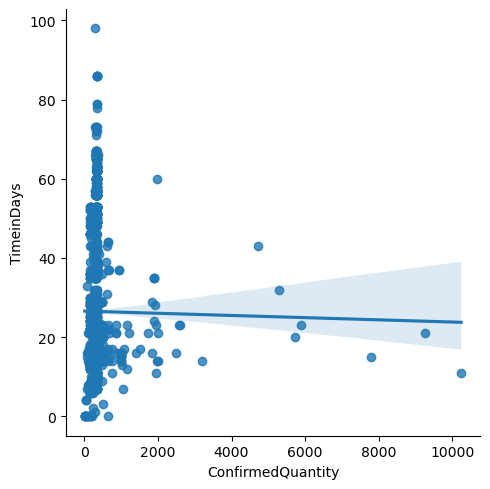

In [25]:
#This is definitely not promising.  P-value is very large, and it is easier to see the lack of correlation with a plot.
sns.lmplot(data=ModelData,x="ConfirmedQuantity",y="TimeinDays")

In [26]:
#This might just be because we apparently have some far outliers for confirmed quantity.  We are most interested in standard
#order size, which is usually between 166 and 666.  So, we will restrict the quantity confirmed to withing a small range.
ModelData = ModelData[(ModelData["ConfirmedQuantity"] > 0) & (ModelData["ConfirmedQuantity"] < 666)]

In [27]:
ModelData["Dimensions"].value_counts()

Dimensions
NoProcess    1248
GL            477
UV            467
FS            338
Name: count, dtype: int64

In [28]:
model1 = ols(formula=formula1, data=ModelData).fit()

In [29]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TimeinDays   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     41.27
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           1.58e-10
Time:                        16:27:36   Log-Likelihood:                -10587.
No. Observations:                2530   AIC:                         2.118e+04
Df Residuals:                    2528   BIC:                         2.119e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            17.5377      1.445     12.135      0.000      14.704      20.372
ConfirmedQuantity     0.0293      0.005      6.424      0.000       0.020       0.038
==============================================================================
Omnibus:                      325.406   Durbin-Watson:                   1.653
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              462.946
Skew:                           1.041   Prob(JB):                    2.97e-101
Kurtosis:                       3.232   Cond. No.                     1.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

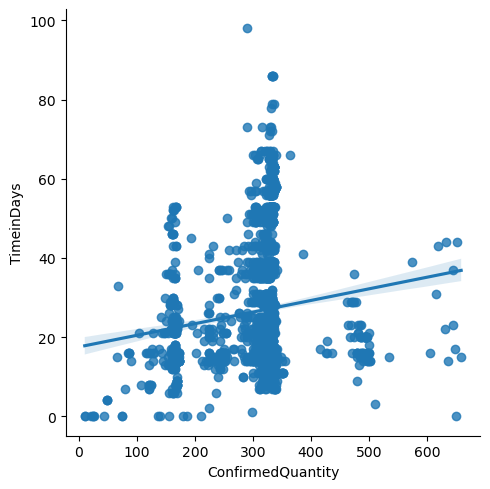

In [30]:
#That's more like it!!  Let's check the lmplot.
sns.lmplot(data=ModelData,x="ConfirmedQuantity",y="TimeinDays")

In [31]:
#The fit is statistically significant, but still not very useful.  The coefficient for quantity is small, which agrees with the
#very small correlations present in the plot.  Let's check a model with only the process categories as factors.
formula2 = "TimeinDays ~ C(Dimensions)"
model2 = ols(formula=formula2, data=ModelData).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TimeinDays   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.741
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           0.000652
Time:                        16:27:36   Log-Likelihood:                -10599.
No. Observations:                2530   AIC:                         2.121e+04
Df Residuals:                    2526   BIC:                         2.123e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     29.0000      0.869     33.370      0.000      27.296      30.704
C(Dimensions)[T.GL]           -1.0755      1.136     -0.947      0.344      -3.303       1.152
C(Dimensions)[T.NoProcess]    -3.5361      0.980     -3.609      0.000      -5.457      -1.615
C(Dimensions)[T.UV]           -2.4690      1.141     -2.164      0.031      -4.706      -0.232
==============================================================================
Omnibus:                      369.450   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              546.880
Skew:                           1.121   Prob(JB):                    1.76e-119
Kurtosis:                       3.397   Cond. No.                         6.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='Dimensions', ylabel='TimeinDays'>

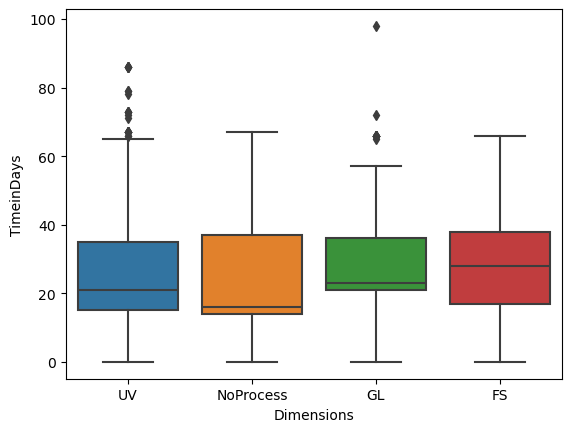

In [32]:
#That's more interesting.  The coefficients for UV and NoProcess are much larger while also being significant.  This suggests
#that whether a order has UV or no-embellishments makes an impact on total time to complete.  Interestingly, the glitter process
#does not appear to be a significant predictor of total completion time.  Below is a plot,
#showing completion time plotted against process as a sanity check.
sns.boxplot(data=ModelData, x="Dimensions", y="TimeinDays")

In [33]:
#Indeed, the completion time for this subset of work orders definitely does not appear to vary strongly based on embellishment.
#However, we can see that the boxes for UV and NoProcess do appear a bit lower than for glitter and foil treatment.

In [34]:
#To improve the model, let's also eliminate outliers for time in days.  Below, we model the majority of work orders, but exclude those
#taking longer than 40 days.
ModelData = ModelData[ModelData["TimeinDays"] <= 40]

In [35]:
ModelData["Dimensions"].value_counts()

Dimensions
NoProcess    998
GL           411
UV           388
FS           268
Name: count, dtype: int64

<Axes: xlabel='Dimensions', ylabel='TimeinDays'>

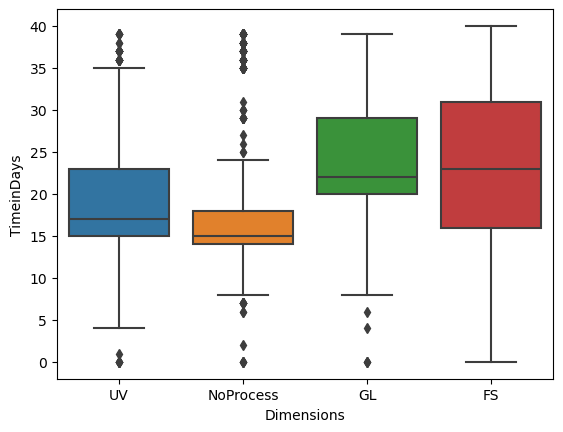

In [36]:
#This is good, because it brings the NoProcess count closer to those with processes and still includes most of the earlier data set.
sns.boxplot(data=ModelData, x="Dimensions", y="TimeinDays")

In [37]:
#Now, we are getting some more variance between processes.  The data is becoming more visible after taking out outliers.
#Now, we rerun model 2.
model2 = ols(formula=formula2, data=ModelData).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TimeinDays   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     66.93
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           2.69e-41
Time:                        16:27:37   Log-Likelihood:                -7298.6
No. Observations:                2065   AIC:                         1.461e+04
Df Residuals:                    2061   BIC:                         1.463e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     23.8470      0.507     47.025      0.000      22.853      24.842
C(Dimensions)[T.GL]           -0.1074      0.652     -0.165      0.869      -1.386       1.171
C(Dimensions)[T.NoProcess]    -5.8791      0.571    -10.293      0.000      -6.999      -4.759
C(Dimensions)[T.UV]           -4.2748      0.659     -6.483      0.000      -5.568      -2.982
==============================================================================
Omnibus:                      201.295   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.434
Skew:                           0.836   Prob(JB):                     1.70e-57
Kurtosis:                       3.490   Cond. No.                         6.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
#The output is similar to before, expect we now see a stronger relationship of NoProcess and UV on the time.
#For a final model, let's remove the data with glitter treatment.  The conclusion from this 2024 data set is that
#processing time seems to not be related to glitter embellishment as I expected.
ModelData = ModelData[ModelData["Dimensions"] != "GL"]

In [39]:
model2 = ols(formula=formula2, data=ModelData).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TimeinDays   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     50.39
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           5.73e-22
Time:                        16:27:37   Log-Likelihood:                -5891.8
No. Observations:                1654   AIC:                         1.179e+04
Df Residuals:                    1651   BIC:                         1.181e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     23.8470      0.521     45.743      0.000      22.824      24.870
C(Dimensions)[T.NoProcess]    -5.8791      0.587    -10.013      0.000      -7.031      -4.727
C(Dimensions)[T.UV]           -4.2748      0.678     -6.306      0.000      -5.604      -2.945
==============================================================================
Omnibus:                      185.835   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.575
Skew:                           0.924   Prob(JB):                     6.39e-55
Kurtosis:                       3.453   Cond. No.                         5.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
#To summarize, based on this limit data subset, an order with either foil, UV, or no embellishment (foil process is reference for
#the modeling in this notebook)
#can be expected to take approximately 24 days, regardless of quantity, and the time
#will decrease by about 6 days if no embellishment is required, or 4 days if only UV is required.